# Modelos de Deep Learning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/lihkir/Data/refs/heads/main/Bitcoin%20Historical%20Data.csv", thousands=',', decimal='.')
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date")
df.sort_index(inplace=True)

df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2010-07-18,0.1,0.0,0.1,0.1,0.08K,0.00%
2010-07-19,0.1,0.1,0.1,0.1,0.57K,0.00%
2010-07-20,0.1,0.1,0.1,0.1,0.26K,0.00%
2010-07-21,0.1,0.1,0.1,0.1,0.58K,0.00%
2010-07-22,0.1,0.1,0.1,0.1,2.16K,0.00%
...,...,...,...,...,...,...
2024-03-20,67854.0,62046.8,68029.5,60850.9,133.53K,9.35%
2024-03-21,65503.8,67860.0,68161.7,64616.1,75.26K,-3.46%
2024-03-22,63785.5,65501.5,66633.3,62328.3,72.43K,-2.62%


In [3]:
# retorno acumulado
def retorno_acumulado(df, columna):
    retorno_diario = (df[columna].diff() / df[columna].shift(1))
    return retorno_diario.cumsum()

def volatilidad(retorno_acum, ventana):
    std_w = retorno_acum.rolling(window=ventana).std()
    return std_w


df["DailyReturn"] = retorno_acumulado(df, "Price")
df["Volatility"] =  volatilidad(df["DailyReturn"], 7)

df

,Price,Open,High,Low,Vol.,Change %,DailyReturn,Volatility
Date,,,,,,,,
2010-07-18,0.1,0.0,0.1,0.1,0.08K,0.00%,NaN,NaN
2010-07-19,0.1,0.1,0.1,0.1,0.57K,0.00%,0.000000,NaN
2010-07-20,0.1,0.1,0.1,0.1,0.26K,0.00%,0.000000,NaN
2010-07-21,0.1,0.1,0.1,0.1,0.58K,0.00%,0.000000,NaN
2010-07-22,0.1,0.1,0.1,0.1,2.16K,0.00%,0.000000,NaN
...,...,...,...,...,...,...,...,...
2024-03-20,67854.0,62046.8,68029.5,60850.9,133.53K,9.35%,23.719802,0.043620
2024-03-21,65503.8,67860.0,68161.7,64616.1,75.26K,-3.46%,23.685166,0.036828
2024-03-22,63785.5,65501.5,66633.3,62328.3,72.43K,-2.62%,23.658934,0.034760


In [4]:
timeserie  = df["Price"]

In [5]:
len(timeserie)

4999

## Split de datos

In [6]:
def split_time_series(data, tau, train_nrows, train_ncols):
    """
    train_ncols: Número de columnas para el train
    train_nrows: Número de filas para el train
    tau: número de rows y cols para val y test
    """
    n_samples = len(data)
    len_dim = train_nrows + tau * 2  # total filas por dim

    splits = []
    id_counter = 1
    dim = 1
    split_counter = 0

    for start in range(n_samples):
        if split_counter == 0:
            if start + len_dim > n_samples:
                break  # No hay suficientes datos
        
        current_dim_start_idx = len(splits)
        
        x_train_end = start + train_ncols
        x_tau_end = start + tau


        # Determinar el tipo de split
        if split_counter < train_nrows:
            split_type = "train"
            X_data = data.iloc[start:x_train_end].values.copy()  # Tomar train_ncols columnas
            y_data = data.iloc[x_train_end:x_train_end +1 ].values.copy()  # y correspondiente a train_nrows
        elif split_counter < train_nrows + tau:
            split_type = "val"
            X_data = data.iloc[start:x_tau_end].values.copy()  # val: tau columnas
            y_data = data.iloc[x_tau_end:x_tau_end + 1].values.copy()  # y correspondiente al tau
        elif split_counter < len_dim:
            split_type = "test"
            X_data = data.iloc[start:x_tau_end].values.copy()  # test: tau columnas
            y_data = data.iloc[x_tau_end:x_tau_end + 1].values.copy()  # y correspondiente al tau
        else:
            dim += 1
            split_counter = 0
            split_type = "train"
            continue
        if len(y_data) == 0:
            break  # algún muestra no tiene y, por tanto, no consideremos este dim

        split_dict = {
            "id": id_counter,
            "dim": dim,
            "split": split_type,
            "X": X_data,
            "y": y_data
        }

        splits.append(split_dict)

        # Contadores
        id_counter += 1
        split_counter += 1

        if split_counter >= len_dim:
            dim += 1
            split_counter = 0

    df = pd.DataFrame(splits)
    dim_ok = df["dim"].value_counts() == len_dim
    df_ok = df.loc[df["dim"].isin(dim_ok[dim_ok].index)].copy()
    return df_ok

df_model = split_time_series(data=timeserie, tau=7, train_nrows=7, train_ncols=7)
df_model

,id,dim,split,X,y
0,1,1,train,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]",[0.1]
1,2,1,train,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]",[0.1]
2,3,1,train,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]",[0.1]
3,4,1,train,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]",[0.1]
4,5,1,train,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]",[0.1]
...,...,...,...,...,...
4972,4973,237,test,"[57056.2, 62467.6, 61169.3, 62397.7, 61994.5, ...",[63792.6]
4973,4974,237,test,"[62467.6, 61169.3, 62397.7, 61994.5, 63135.8, ...",[66080.4]
4974,4975,237,test,"[61169.3, 62397.7, 61994.5, 63135.8, 68270.1, ...",[66855.3]
4975,4976,237,test,"[62397.7, 61994.5, 63135.8, 68270.1, 63792.6, ...",[68172.0]


In [7]:
## PENDIENTE
def plot_splits(data, splits, horizon, dim=1):
    return 1

## Conjuntos de datos a evaluar

In [8]:
series_name = ["Price", "DailyReturn","Volatility"]
tau_list = [7,14,21,28]
train_lens = [7,14,21,28]

datasets = {}

for serie, tau, train_nrows, train_ncols in itertools.product(series_name, tau_list, train_lens, train_lens):
    key = f"{serie}_tau{tau}_train_rows{train_nrows}_train_cols{train_ncols}"
    dataset = split_time_series(data=df[serie], tau=tau, train_nrows=train_nrows, train_ncols=train_ncols)
    datasets[key] = dataset

In [9]:
#Vemos uno de los datasets=
datasets.get("Price_tau7_train_rows7_train_cols7").tail(30)

,id,dim,split,X,y
4947,4948,236,val,"[43194.7, 43005.7, 42581.4, 42697.2, 43087.7, ...",[47127.5]
4948,4949,236,val,"[43005.7, 42581.4, 42697.2, 43087.7, 44339.8, ...",[47758.2]
4949,4950,236,test,"[42581.4, 42697.2, 43087.7, 44339.8, 45293.3, ...",[48277.3]
4950,4951,236,test,"[42697.2, 43087.7, 44339.8, 45293.3, 47127.5, ...",[49941.3]
4951,4952,236,test,"[43087.7, 44339.8, 45293.3, 47127.5, 47758.2, ...",[49716.0]
4952,4953,236,test,"[44339.8, 45293.3, 47127.5, 47758.2, 48277.3, ...",[51782.4]
4953,4954,236,test,"[45293.3, 47127.5, 47758.2, 48277.3, 49941.3, ...",[51901.3]
4954,4955,236,test,"[47127.5, 47758.2, 48277.3, 49941.3, 49716.0, ...",[52134.2]
4955,4956,236,test,"[47758.2, 48277.3, 49941.3, 49716.0, 51782.4, ...",[51646.0]
4956,4957,237,train,"[48277.3, 49941.3, 49716.0, 51782.4, 51901.3, ...",[52117.5]


In [10]:
count = 0
for key in datasets.keys():
    count += len(datasets.get(key).dim.unique())
    
print(f"Hay en total {count} pliegues (o 'dims') para entrenar los modelos")

Hay en total 20832 pliegues (o 'dims') para entrenar los modelos


In [11]:
len(datasets.keys())

192

## Entrenamiento y validación

### Un modelo (testing)

In [12]:
import keras.backend as K
import statsmodels.api as sm
import tensorflow as tf
from scipy import stats
import gc
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, root_mean_squared_error, mean_squared_error,r2_score
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import jarque_bera
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf

In [13]:
devices = tf.config.list_physical_devices()
print("Available devices:")
for device in devices:
    print(device)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("TensorFlow is using GPU.")
    for gpu in gpus:
        gpu_details = tf.config.experimental.get_device_details(gpu)
        print(f"GPU details: {gpu_details}")
else:
    print("TensorFlow is not using GPU.")

Available devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
TensorFlow is using GPU.
GPU details: {'device_name': 'NVIDIA GeForce RTX 2060 SUPER', 'compute_capability': (7, 5)}


In [14]:
dim = 60

df_dim = df_model.loc[df_model["dim"] == dim]

split = "train"
X_train, y_train = df_dim.loc[df_dim["split"] == split, "X"].tolist(), df_dim.loc[df_dim["split"] == split, "y"].tolist()
X_train, y_train = np.array([np.array(xi).flatten() for xi in X_train]), np.array([np.array(yi).flatten() for yi in y_train])


split = "val"
X_val, y_val = df_dim.loc[df_dim["split"] == split, "X"].tolist(), df_dim.loc[df_dim["split"] == split, "y"].tolist()
X_val, y_val = np.array([np.array(xi).flatten() for xi in X_val]), np.array([np.array(yi).flatten() for yi in y_val])

split = "test"
X_test, y_test = df_dim.loc[df_dim["split"] == split, "X"].tolist(), df_dim.loc[df_dim["split"] == split, "y"].tolist()
X_test, y_test = np.array([np.array(xi).flatten() for xi in X_test]), np.array([np.array(yi).flatten() for yi in y_test])

# Re-dimensionar los datos para RNN/LSTM
X_train_rnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_rnn = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test_rnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


#pendiente llevarlo a función
def get_batch(df, dim):
    dim_df = df_model.loc[df_model["dim"] == 100]

    # return X_train, y_train, X_val, y_val

X_train

array([[ 804. ,  919. , 1033.7,  919.9,  900. ,  936.8,  908.9],
       [ 919. , 1033.7,  919.9,  900. ,  936.8,  908.9,  919.9],
       [1033.7,  919.9,  900. ,  936.8,  908.9,  919.9,  759.9],
       [ 919.9,  900. ,  936.8,  908.9,  919.9,  759.9,  715. ],
       [ 900. ,  936.8,  908.9,  919.9,  759.9,  715. ,  541. ],
       [ 936.8,  908.9,  919.9,  759.9,  715. ,  541. ,  732. ],
       [ 908.9,  919.9,  759.9,  715. ,  541. ,  732. ,  650. ]])

In [15]:
def calculate_metrics(y_true, y_pred):
    rmse = root_mean_squared_error(y_true, y_pred)
    metrics = {
        "MAPE": mean_absolute_percentage_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": rmse,
        "MSE": rmse**2,
        "R2": r2_score(y_true, y_pred)
    }
    return metrics

# Metricas adicionales para los modelos:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def r2_metric(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res/(SS_tot + K.epsilon())

def create_and_train_model(model_type, neurons, dropout_rate, batch_size, X_train, y_train, X_val, y_val):

    model = Sequential()
    if model_type == 'MLP':
        # (samples, features)
        model.add(Dense(neurons, activation='relu', input_shape=(X_train.shape[1],)))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1))

    elif model_type == 'RNN':
        #(samples, timesteps, features)
        model.add(SimpleRNN(neurons, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1))

    elif model_type == 'LSTM':
        #(samples, timesteps, features)
        model.add(LSTM(neurons, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1))

    else:
        raise ValueError("Modeo inválido")

    model.compile(optimizer=Adam(), loss='mse', metrics=['mape','mae', 'mse'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(f'models/best_model_{model_type}.h5', save_best_only=True, monitor='val_loss')

    history = model.fit(X_train, y_train, epochs=100, batch_size=batch_size,
                        validation_data=(X_val, y_val), verbose=0,
                        callbacks=[early_stopping, model_checkpoint])
    return model, history

In [16]:
model_type = 'MLP'
neurons = 1000
dropout_rate = 0.2
batch_size = 16

model_mlp, history_mlp = create_and_train_model(model_type, neurons, dropout_rate, batch_size,
                                                X_train, y_train, X_val, y_val)


In [17]:
model_type = 'RNN'
model_rnn, history_rnn = create_and_train_model(model_type, neurons, dropout_rate, batch_size,
                                                X_train_rnn, y_train, X_val_rnn, y_val)

In [18]:
model_type = 'LSTM'
model_lstm, history_lstm = create_and_train_model(model_type, neurons, dropout_rate, batch_size,
                                                  X_train_rnn, y_train, X_val_rnn, y_val)

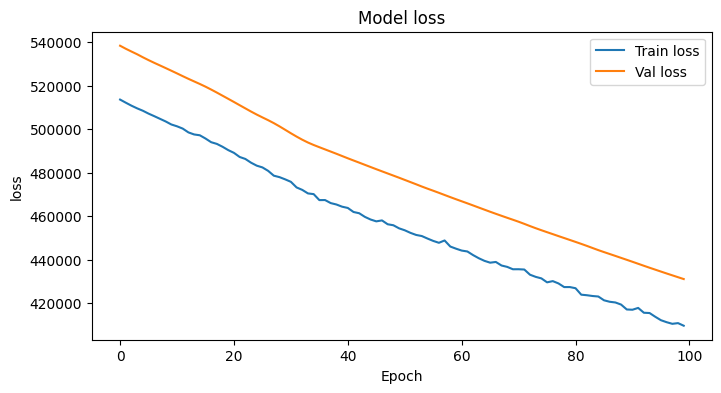

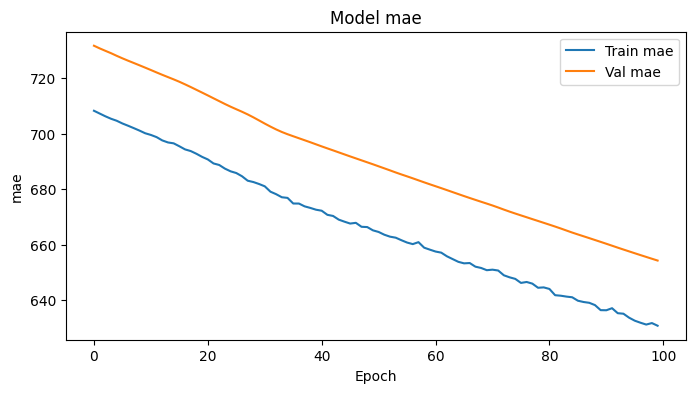

In [19]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Métricas disponibles en history.history
    metrics = ['loss', 'mae']
    for metric in metrics:
        plt.figure(figsize=(8, 4))
        plt.plot(history.history[metric], label=f'Train {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Val {metric}')
        plt.title(f'Model {metric}')
        plt.ylabel(metric)
        plt.xlabel('Epoch')
        plt.legend()
        plt.show()

# Ejemplo para el modelo LSTM
plot_training_history(history_lstm)


In [20]:
# Seleccionar el modelo y los datos correspondientes
#model = model_rnn  # o model_mlp, model_rnn
model_type == 'RNN'
model = load_model('models/best_model_RNN.h5')

# Metricas con train
X_train_model = X_train if model_type == 'MLP' else X_train_rnn
y_train_pred = model.predict(X_train_model)
y_train_true = y_train
metricas_train = calculate_metrics(y_train_true, y_train_pred)
resid_train = y_train_true - y_train_pred

# Metricas con test
X_test_model = X_test if model_type == 'MLP' else X_test_rnn
y_test_pred = model.predict(X_test_model)
y_test_true = y_test
metricas_test = calculate_metrics(y_test_true, y_test_pred)
resid_test = y_test_true - y_test_pred

print("Resultados de las métricas de entrenamiento:")
for metric_name, metric_value in metricas_train.items():
    print(f"{metric_name}: {metric_value}")

print("---------------------------------------------")
print("Resultados de las métricas de prueba:")
for metric_name, metric_value in metricas_test.items():
    print(f"{metric_name}: {metric_value}")


1/1 [==============================] - 0s 18ms/step
Resultados de las métricas de entrenamiento:
MAPE: 0.8534659582119735
MAE: 606.9302483694894
RMSE: 616.7401628130491
MSE: 380368.4284266663
R2: -30.68653741307249
---------------------------------------------
Resultados de las métricas de prueba:
MAPE: 0.8788697616938188
MAE: 738.2445340837751
RMSE: 739.7358507192038
MSE: 547209.1288392642
R2: -247.26460183980515


In [21]:

# Prueba de Ljung-Box
max_lag_test = min(10, len(resid_train) - 1)
if max_lag_test >= 1:
    ljung_box_result = acorr_ljungbox(resid_train, lags=[max_lag_test], return_df=True)
    ljung_box_pvalue = ljung_box_result['lb_pvalue'].values[0]
else:
    ljung_box_pvalue = np.nan

ljung_box_pvalue

0.6384917982042451

In [22]:


# Prueba de Jarque-Bera
jb_test = stats.jarque_bera(resid_train)
jarque_bera_p_value = jb_test[1]
jarque_bera_p_value

0.8689782414183287

In [23]:
results_df = pd.DataFrame({
    "MAPE": [metricas_train['MAPE']],
    "MAE": [metricas_train['MAE']],
    "RMSE": [metricas_train['RMSE']],
    "MSE": [metricas_train['MSE']],
    "R2": [metricas_train['R2']],
    "Ljung-Box test (p-value)": [ljung_box_pvalue],
    "Jarque-Bera (p-value)": [jarque_bera_p_value]
})

In [24]:
results_df

,MAPE,MAE,RMSE,MSE,R2,Ljung-Box test (p-value),Jarque-Bera (p-value)
0,0.853466,606.930248,616.740163,380368.428427,-30.686537,0.638492,0.868978


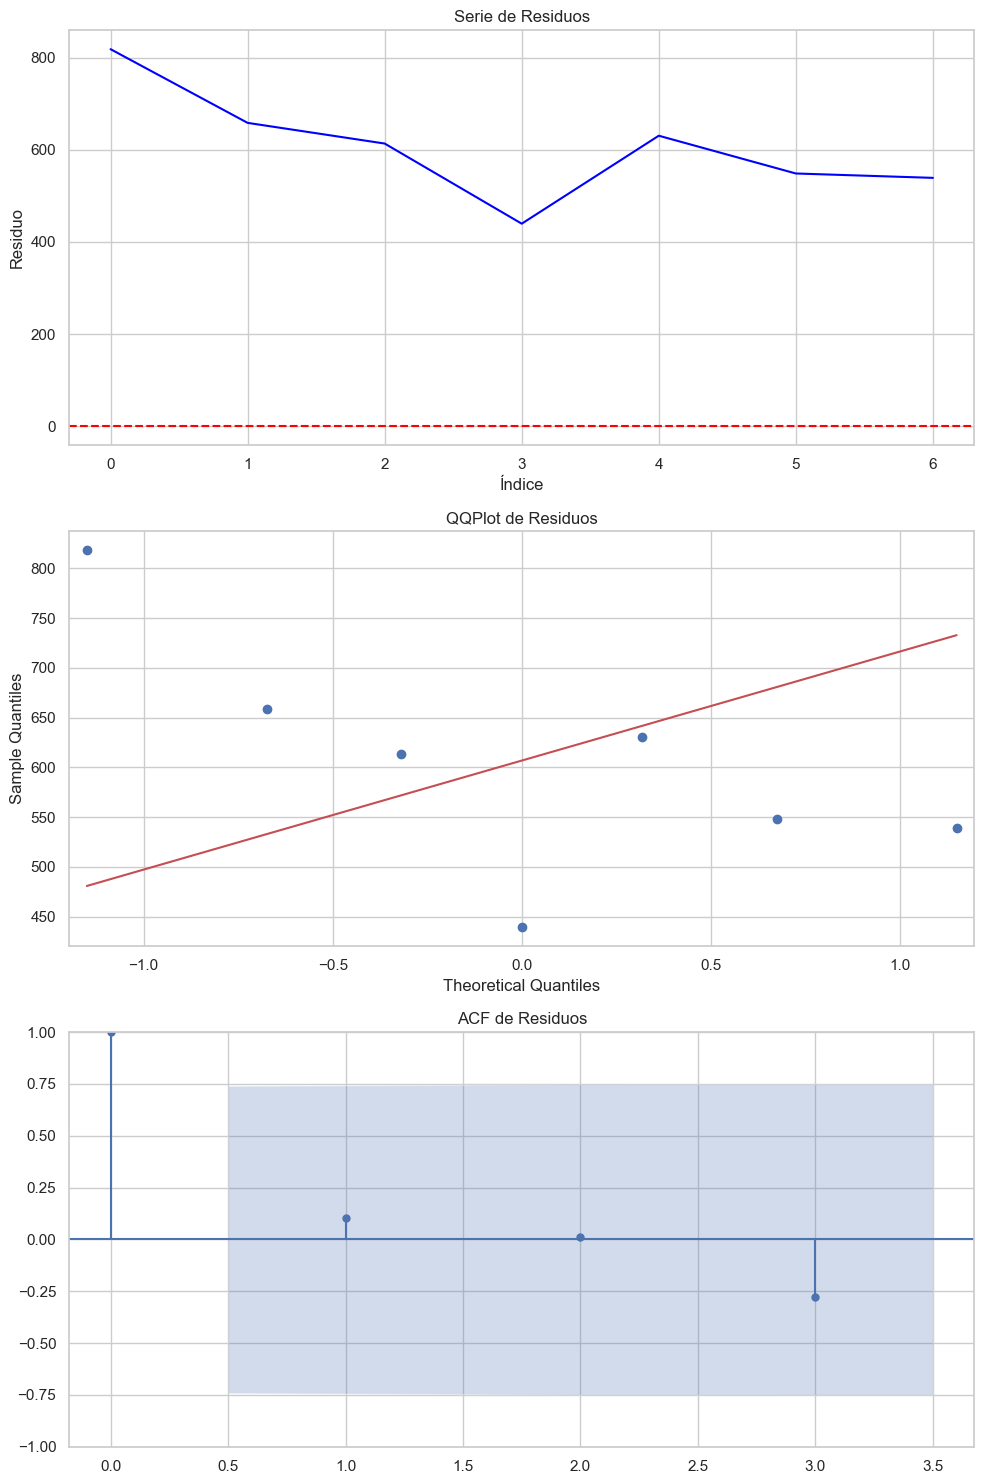

In [25]:

def plot_residuals(resid):
    sns.set_theme(style="whitegrid")
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))
    
    # Gráfica de la Serie de Residuos
    axs[0].plot(resid, color='blue')
    axs[0].axhline(0, color='red', linestyle='--')
    axs[0].set_title('Serie de Residuos')
    axs[0].set_xlabel('Índice')
    axs[0].set_ylabel('Residuo')

    # Gráfica QQPlot
    sm.qqplot(resid, line='s', ax=axs[1])
    axs[1].set_title('QQPlot de Residuos')

    # Gráfica ACF de Residuos
    plot_acf(resid, ax=axs[2])
    axs[2].set_title('ACF de Residuos')

    plt.tight_layout()
    plt.show()


plot_residuals(resid_train)

In [91]:
def create_and_train_model(model_type, neurons, dropout_rate, batch_size, X_train, y_train, X_val, y_val, key):
    model = Sequential()
    if model_type == 'MLP':
        # (samples, features)
        model.add(Dense(neurons, activation='relu', input_shape=(X_train.shape[1],)))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1))

    elif model_type == 'RNN':
        #(samples, timesteps, features)
        model.add(SimpleRNN(neurons, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1))

    elif model_type == 'LSTM':
        #(samples, timesteps, features)
        model.add(LSTM(neurons, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1))

    else:
        raise ValueError("Modelo inválido")

    model.compile(optimizer=Adam(), loss='mse', metrics=['mape','mae', 'mse'])

    checkpoint_dir = f'models/{key}'
    os.makedirs(checkpoint_dir, exist_ok=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(
        f'{checkpoint_dir}/best_model_{model_type}.h5',
        save_best_only=True,
        monitor='val_loss'
    )

    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=0,
        callbacks=[early_stopping, model_checkpoint]
    )
    return model, history

# Definición de la función para procesar y entrenar modelos
def process_and_train_models(key, df_model, model_types, neurons, dropout_rate, batch_size):
    """
    Procesa los datos para cada dim y entrena modelos de diferentes tipos.
    """
    resultados_entrenamiento = []
    resultados_test = []
    unique_dims = df_model["dim"].unique()

    for dim in unique_dims:
        df_dim = df_model.loc[df_model["dim"] == dim]

        # Procesar datos para entrenamiento, validación y prueba
        splits = {}
        for split in ["train", "val", "test"]:
            X_split, y_split = (
                df_dim.loc[df_dim["split"] == split, "X"].tolist(),
                df_dim.loc[df_dim["split"] == split, "y"].tolist()
            )
            X_split = np.array([np.array(xi).flatten() for xi in X_split])
            y_split = np.array([np.array(yi).flatten() for yi in y_split])
            splits[split] = (X_split, y_split)

        # Escalar los datos
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()

        X_train, y_train = splits["train"]
        X_train_scaled = scaler_X.fit_transform(X_train)
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

        X_val, y_val = splits["val"]
        X_val_scaled = scaler_X.transform(X_val)
        y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()

        X_test, y_test = splits["test"]
        X_test_scaled = scaler_X.transform(X_test)
        y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

        # Re-dimensionar para RNN/LSTM
        X_train_rnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
        X_val_rnn = X_val_scaled.reshape((X_val_scaled.shape[0], X_val_scaled.shape[1], 1))
        X_test_rnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

        # Actualizar splits con datos escalados
        splits_scaled = {
            "train": (X_train_scaled, y_train_scaled),
            "val": (X_val_scaled, y_val_scaled),
            "test": (X_test_scaled, y_test_scaled),
            "train_rnn": (X_train_rnn, y_train_scaled),
            "val_rnn": (X_val_rnn, y_val_scaled),
            "test_rnn": (X_test_rnn, y_test_scaled)
        }

        # Entrenar y evaluar modelos
        for model_type in model_types:
            if model_type in ['RNN', 'LSTM']:
                X_train_model, y_train_model = splits_scaled["train_rnn"]
                X_val_model, y_val_model = splits_scaled["val_rnn"]
                X_test_model, y_test_model = splits_scaled["test_rnn"]
            elif model_type == 'MLP':
                X_train_model, y_train_model = splits_scaled["train"]
                X_val_model, y_val_model = splits_scaled["val"]
                X_test_model, y_test_model = splits_scaled["test"]
            else:
                raise ValueError(f"Tipo de modelo desconocido: {model_type}")

            # Entrenar el modelo
            model, history = create_and_train_model(
                model_type=model_type,
                neurons=neurons,
                dropout_rate=dropout_rate,
                batch_size=batch_size,
                X_train=X_train_model,
                y_train=y_train_model,
                X_val=X_val_model,
                y_val=y_val_model,
                key=key
            )

            # Evaluar en el conjunto de entrenamiento
            y_train_pred = model.predict(X_train_model).flatten()
            residuals_train = y_train_model - y_train_pred

            mape_train = mean_absolute_percentage_error(y_train_model, y_train_pred)
            mae_train = mean_absolute_error(y_train_model, y_train_pred)
            mse_train = mean_squared_error(y_train_model, y_train_pred)
            rmse_train = root_mean_squared_error(y_train_model, y_train_pred)
            r2_train = r2_score(y_train_model, y_train_pred)
            
            jb_test = stats.jarque_bera(residuals_train)
            jarque_bera_p_value = jb_test[1]
            
            # Pruebas estadísticas en los residuos de entrenamiento
            max_lag = min(10, len(residuals_train) - 1)
            if max_lag >= 1:
                ljung_box_result = acorr_ljungbox(residuals_train, lags=[max_lag], return_df=True)
                ljung_box_pvalue = ljung_box_result['lb_pvalue'].values[0]
            else:
                ljung_box_pvalue = np.nan

            # Guardar figuras
            fig_dir = f'figures/{key}/{model_type}/dim_{dim}'
            os.makedirs(fig_dir, exist_ok=True)

            residuals_plot_path = os.path.join(fig_dir, 'residuals_analysis.png')
            plot_residuals(residuals_train, residuals_plot_path)

            # Almacenar los resultados en el conjunto de entrenamiento
            resultado_entrenamiento = {
                "key": key,
                "dim": dim,
                "model_type": model_type,
                "neurons": neurons,
                "dropout_rate": dropout_rate,
                "batch_size": batch_size,
                "MAPE": mape_train,
                "MAE": mae_train,
                "RMSE": rmse_train,
                "MSE": mse_train,
                "R2": r2_train,
                "Ljung_Box_pvalue": ljung_box_pvalue,
                "Jarque_Bera_pvalue": jarque_bera_p_value
            }
            resultados_entrenamiento.append(resultado_entrenamiento)

            # Evaluar en el conjunto de prueba
            y_test_pred = model.predict(X_test_model).flatten()
            residuals_test = y_test_model - y_test_pred

            mape_test = mean_absolute_percentage_error(y_test_model, y_test_pred)
            mae_test = mean_absolute_error(y_test_model, y_test_pred)
            mse_test = mean_squared_error(y_test_model, y_test_pred)
            rmse_test = root_mean_squared_error(y_test_model, y_test_pred)
            r2_test = r2_score(y_test_model, y_test_pred)

            # Prueba de independencia en los residuos de prueba
            max_lag_test = min(10, len(residuals_test) - 1)
            if max_lag_test >= 1:
                ljung_box_result_test = acorr_ljungbox(residuals_test, lags=[max_lag_test], return_df=True)
                ljung_box_pvalue_test = ljung_box_result_test['lb_pvalue'].values[0]
            else:
                ljung_box_pvalue_test = np.nan

            # Almacenar los resultados en el conjunto de prueba
            resultado_test = {
                "key": key,
                "dim": dim,
                "model_type": model_type,
                "neurons": neurons,
                "dropout_rate": dropout_rate,
                "batch_size": batch_size,
                "MAPE": mape_test,
                "MAE": mae_test,
                "RMSE": rmse_test,
                "MSE": mse_test,
                "R2": r2_test,
                "Ljung_Box_pvalue": ljung_box_pvalue_test
            }
            resultados_test.append(resultado_test)


            plt.figure()
            epochs = range(1, len(history.history['loss']) + 1)
            plt.plot(epochs, history.history['loss'], label='Loss Entrenamiento')
            plt.plot(epochs, history.history['val_loss'], label='Loss Validación')
            plt.title('Curva de Entrenamiento')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.savefig(f'{fig_dir}/training_history.png')
            plt.close()

    results_dir = f'results/{key}/{model_type}/dim_{dim}'
    os.makedirs(results_dir, exist_ok=True)
    
    pd.DataFrame(resultados_entrenamiento).to_csv(f'{results_dir}/results_train.csv')
    pd.DataFrame(resultados_test).to_csv(f'{results_dir}/results_test.csv')
    return print(f'Resultados del modelo {results_dir} guardados exitosamente')

1/1 [==============================] - 0s 131ms/step


KeyboardInterrupt: 

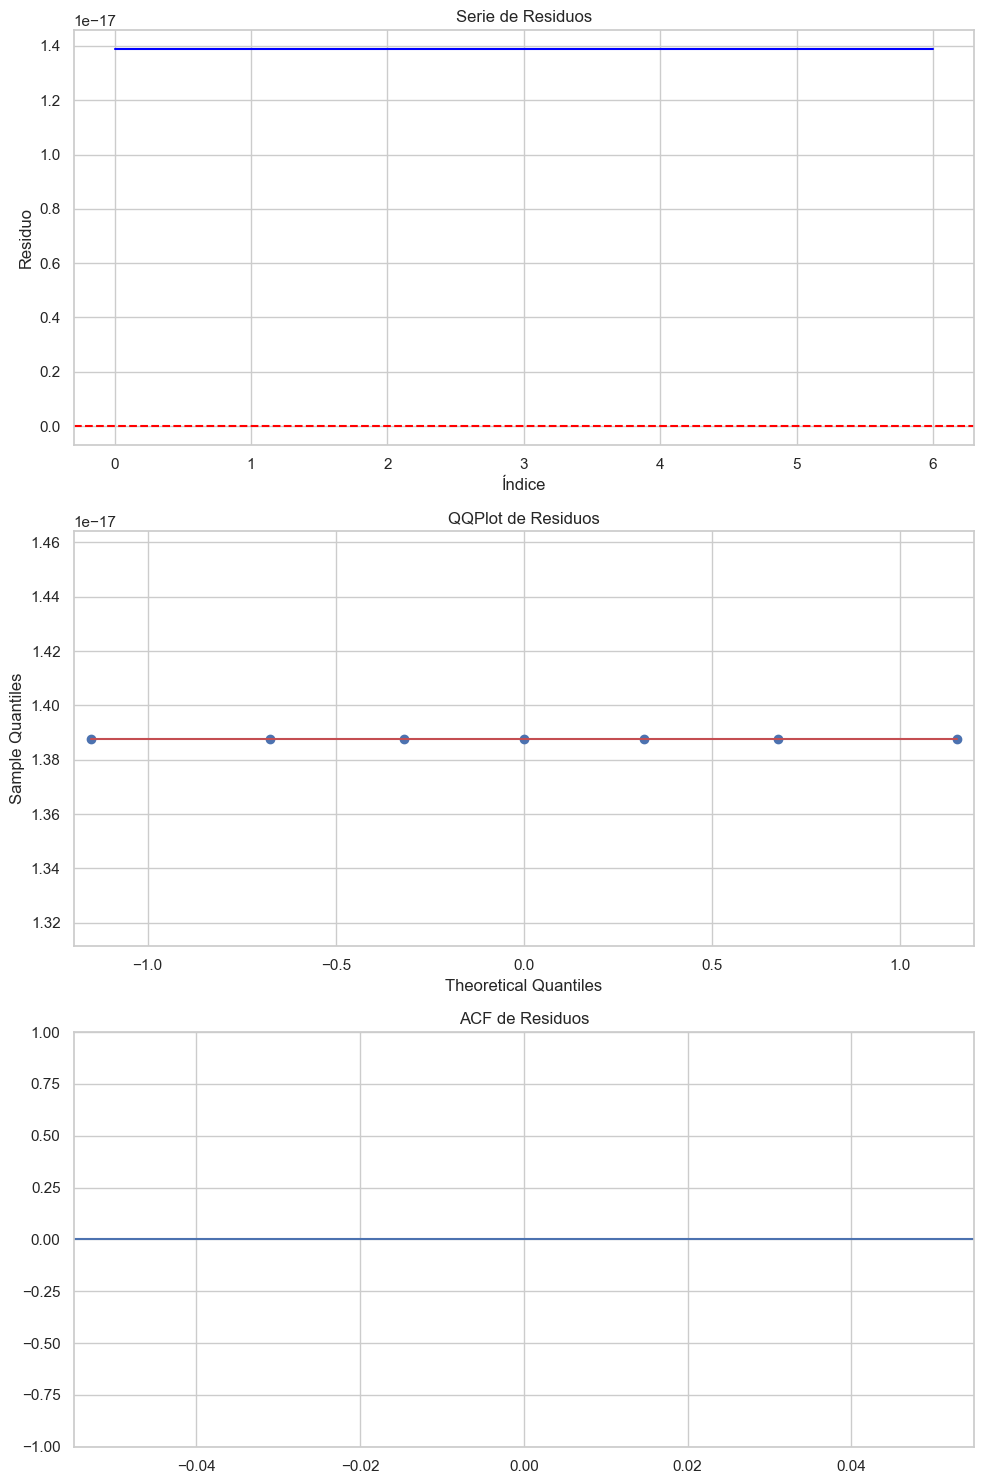

In [92]:
key = "Price_tau7_train_rows7_train_cols7"
#config = (key, datasets.get(key) ,10, 0.2, 16, ['RNN'])
process_and_train_models(key, datasets.get(key),['RNN'],10, 0.2, 16)

### Procesamiento por lotes Modelos

In [26]:
from joblib import Parallel, delayed
import logging

In [85]:
def plot_residuals(resid, save_path):
    """
    Genera y guarda una figura con tres subplots
    """
    sns.set_theme(style="whitegrid")
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))
    
    #Serie de Residuos
    axs[0].plot(resid, color='blue')
    axs[0].axhline(0, color='red', linestyle='--')
    axs[0].set_title('Serie de Residuos')
    axs[0].set_xlabel('Índice')
    axs[0].set_ylabel('Residuo')

    #QQPlot de Residuos
    sm.qqplot(resid, line='s', ax=axs[1])
    axs[1].set_title('QQPlot de Residuos')

    #ACF de Residuos
    plot_acf(resid, ax=axs[2], lags=min(20, len(resid)-1))
    axs[2].set_title('ACF de Residuos')

    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

def create_and_train_model(model_type, neurons, dropout_rate, batch_size, X_train, y_train, X_val, y_val, key, dim):
    """
    Función para configurar el modelo y guardar el mejor
    """
    model = Sequential()
    if model_type == 'MLP':
        # (samples, features)
        model.add(Dense(neurons, activation='relu', input_shape=(X_train.shape[1],)))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1))

    elif model_type == 'RNN':
        #(samples, timesteps, features)
        model.add(SimpleRNN(neurons, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1))

    elif model_type == 'LSTM':
        #(samples, timesteps, features)
        model.add(LSTM(neurons, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1))

    else:
        raise ValueError("Modelo inválido")

    model.compile(optimizer=Adam(), loss='mse', metrics=['mape','mae', 'mse'])

    checkpoint_dir = f'models/{key}/{model_type}/dim_{dim}'
    os.makedirs(checkpoint_dir, exist_ok=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(f'{checkpoint_dir}/best_model_{model_type}_dim_{dim}.h5', save_best_only=True, monitor='val_loss')

    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=0,
        callbacks=[early_stopping, model_checkpoint]
    )
    return model, history

def process_and_train_models(config):
    """
    Procesa los datos para cada dim y entrena modelos de diferentes tipos.
    """
    key, df_model ,neurons, dropout_rate, batch_size, model_types = config
    resultados_entrenamiento = []
    resultados_test = []
    unique_dims = df_model["dim"].unique()
    for dim in unique_dims:
        df_dim = df_model.loc[df_model["dim"] == dim]

        # Procesar datos para entrenamiento, validación y prueba
        splits = {}
        for split in ["train", "val", "test"]:
            X_split, y_split = (
                df_dim.loc[df_dim["split"] == split, "X"].tolist(),
                df_dim.loc[df_dim["split"] == split, "y"].tolist()
            )
            X_split = np.array([np.array(xi).flatten() for xi in X_split])
            y_split = np.array([np.array(yi).flatten() for yi in y_split])
            splits[split] = (X_split, y_split)

        # Escalar los datos
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()

        X_train, y_train = splits["train"]
        X_train_scaled = scaler_X.fit_transform(X_train)
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

        X_val, y_val = splits["val"]
        X_val_scaled = scaler_X.transform(X_val)
        y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()

        X_test, y_test = splits["test"]
        X_test_scaled = scaler_X.transform(X_test)
        y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

        # Re-dimensionar para RNN/LSTM
        X_train_rnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
        X_val_rnn = X_val_scaled.reshape((X_val_scaled.shape[0], X_val_scaled.shape[1], 1))
        X_test_rnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

        # Actualizar splits con datos escalados
        splits_scaled = {
            "train": (X_train_scaled, y_train_scaled),
            "val": (X_val_scaled, y_val_scaled),
            "test": (X_test_scaled, y_test_scaled),
            "train_rnn": (X_train_rnn, y_train_scaled),
            "val_rnn": (X_val_rnn, y_val_scaled),
            "test_rnn": (X_test_rnn, y_test_scaled)
        }

        # Entrenar y evaluar modelos
        for model_type in model_types:
            try:
                if model_type in ['RNN', 'LSTM']:
                    X_train_model, y_train_model = splits_scaled["train_rnn"]
                    X_val_model, y_val_model = splits_scaled["val_rnn"]
                    X_test_model, y_test_model = splits_scaled["test_rnn"]
                elif model_type == 'MLP':
                    X_train_model, y_train_model = splits_scaled["train"]
                    X_val_model, y_val_model = splits_scaled["val"]
                    X_test_model, y_test_model = splits_scaled["test"]
                else:
                    raise ValueError(f"Tipo de modelo desconocido: {model_type}")

                # Entrenar el modelo
                model, history = create_and_train_model(
                    model_type=model_type,
                    neurons=neurons,
                    dropout_rate=dropout_rate,
                    batch_size=batch_size,
                    X_train=X_train_model,
                    y_train=y_train_model,
                    X_val=X_val_model,
                    y_val=y_val_model,
                    key=key,
                    dim=dim
                )

                # Evaluar en el conjunto de entrenamiento
                y_train_pred = model.predict(X_train_model).flatten()
                residuals_train = y_train_model - y_train_pred

                mape_train = mean_absolute_percentage_error(y_train_model, y_train_pred)
                mae_train = mean_absolute_error(y_train_model, y_train_pred)
                mse_train = mean_squared_error(y_train_model, y_train_pred)
                rmse_train = root_mean_squared_error(y_train_model, y_train_pred)
                r2_train = r2_score(y_train_model, y_train_pred)
                
                jb_test = stats.jarque_bera(residuals_train)
                jarque_bera_p_value = jb_test[1]
                
                # Pruebas estadísticas en los residuos de entrenamiento
                max_lag = min(10, len(residuals_train) - 1)
                if max_lag >= 1:
                    ljung_box_result = acorr_ljungbox(residuals_train, lags=[max_lag], return_df=True)
                    ljung_box_pvalue = ljung_box_result['lb_pvalue'].values[0]
                else:
                    ljung_box_pvalue = np.nan

                # Guardar figuras
                fig_dir = f'figures/{key}/{model_type}/dim_{dim}'
                os.makedirs(fig_dir, exist_ok=True)

                residuals_plot_path = os.path.join(fig_dir, 'residuals_analysis.png')
                plot_residuals(residuals_train, residuals_plot_path)

                resultado_entrenamiento = {
                    "key": key,
                    "dim": dim,
                    "model_type": model_type,
                    "neurons": neurons,
                    "dropout_rate": dropout_rate,
                    "batch_size": batch_size,
                    "MAPE": mape_train,
                    "MAE": mae_train,
                    "RMSE": rmse_train,
                    "MSE": mse_train,
                    "R2": r2_train,
                    "Ljung_Box_pvalue": ljung_box_pvalue,
                    "Jarque_Bera_pvalue": jarque_bera_p_value
                }
                resultados_entrenamiento.append(resultado_entrenamiento)

                # Evaluar en el conjunto de prueba
                y_test_pred = model.predict(X_test_model).flatten()
                residuals_test = y_test_model - y_test_pred

                mape_test = mean_absolute_percentage_error(y_test_model, y_test_pred)
                mae_test = mean_absolute_error(y_test_model, y_test_pred)
                mse_test = mean_squared_error(y_test_model, y_test_pred)
                rmse_test = root_mean_squared_error(y_test_model, y_test_pred)
                r2_test = r2_score(y_test_model, y_test_pred)

                max_lag_test = min(10, len(residuals_test) - 1)
                if max_lag_test >= 1:
                    ljung_box_result_test = acorr_ljungbox(residuals_test, lags=[max_lag_test], return_df=True)
                    ljung_box_pvalue_test = ljung_box_result_test['lb_pvalue'].values[0]
                else:
                    ljung_box_pvalue_test = np.nan

                # Resultados de test
                resultado_test = {
                    "key": key,
                    "dim": dim,
                    "model_type": model_type,
                    "neurons": neurons,
                    "dropout_rate": dropout_rate,
                    "batch_size": batch_size,
                    "MAPE": mape_test,
                    "MAE": mae_test,
                    "RMSE": rmse_test,
                    "MSE": mse_test,
                    "R2": r2_test,
                    "Ljung_Box_pvalue": ljung_box_pvalue_test
                }
                resultados_test.append(resultado_test)

                # Guardar la curva de entrenamiento (Runs vs Error/Score)
                plt.figure()
                epochs = range(1, len(history.history['loss']) + 1)
                plt.plot(epochs, history.history['loss'], label='Loss Entrenamiento')
                plt.plot(epochs, history.history['val_loss'], label='Loss Validación')
                plt.title('Curva de Entrenamiento')
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                plt.legend()
                plt.savefig(f'{fig_dir}/training_history.png')
                plt.close()

                # Liberar memoria
                del model, history, residuals_train, residuals_test
                gc.collect()

            except Exception as e:
                print(f"Error al entrenar {model_type} para key={key}, dim={dim}: {e}")
                continue
            
            return resultado_test



In [ ]:
        try:
            results_dir = f'results/{key}'
            os.makedirs(results_dir, exist_ok=True)
            
            # Nombre de los archivos CSV que incluye los parámetros
            train_csv_path = f'{results_dir}/results_train_neurons{neurons}_dropout{dropout_rate}_batch{batch_size}.csv'
            test_csv_path = f'{results_dir}/results_test_neurons{neurons}_dropout{dropout_rate}_batch{batch_size}.csv'
            
            pd.DataFrame(resultados_entrenamiento).to_csv(train_csv_path, index=False)
            pd.DataFrame(resultados_test).to_csv(test_csv_path, index=False)
            print(f"Entrenamiento exitoso para key={key}, neurons={neurons}, dropout={dropout_rate}, batch_size={batch_size}.")
            return {
                "key": key,
                "neurons": neurons,
                "dropout_rate": dropout_rate,
                "batch_size": batch_size,
                "status": "success",
                "results_dir": results_dir
            }
        except Exception as e:
            print(f"Error al guardar resultados para key={key}, neurons={neurons}, dropout={dropout_rate}, batch_size={batch_size}: {e}")
            return {
                "key": key,
                "neurons": neurons,
                "dropout_rate": dropout_rate,
                "batch_size": batch_size,
                "status": "failed",
                "error": str(e)
            }
            continue

### Paralización de la ejecución

In [86]:
key = "Price_tau7_train_rows7_train_cols7"
config = (key, datasets.get(key) ,10, 0.2, 16, ['RNN'])
process_and_train_models(config)

1/1 [==============================] - 0s 20ms/step


{'key': 'Price_tau7_train_rows7_train_cols7',
 'dim': 1,
 'model_type': 'RNN',
 'neurons': 10,
 'dropout_rate': 0.2,
 'batch_size': 16,
 'MAPE': 0.0625,
 'MAE': 1.3877787807814457e-17,
 'RMSE': 1.3877787807814457e-17,
 'MSE': 1.925929944387236e-34,
 'R2': 0.0,
 'Ljung_Box_pvalue': nan}

In [77]:
datasets.get("Price_tau7_train_rows7_train_cols7")

,id,dim,split,X,y
0,1,1,train,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]",[0.1]
1,2,1,train,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]",[0.1]
2,3,1,train,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]",[0.1]
3,4,1,train,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]",[0.1]
4,5,1,train,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]",[0.1]
...,...,...,...,...,...
4972,4973,237,test,"[57056.2, 62467.6, 61169.3, 62397.7, 61994.5, ...",[63792.6]
4973,4974,237,test,"[62467.6, 61169.3, 62397.7, 61994.5, 63135.8, ...",[66080.4]
4974,4975,237,test,"[61169.3, 62397.7, 61994.5, 63135.8, 68270.1, ...",[66855.3]
4975,4976,237,test,"[62397.7, 61994.5, 63135.8, 68270.1, 63792.6, ...",[68172.0]


In [70]:
import multiprocessing as mp

def configure_tf():
    K.set_floatx('float16')
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
    physical_devices = tf.config.list_physical_devices('GPU')
    if physical_devices:
        try:
            for device in physical_devices:
                tf.config.experimental.set_memory_growth(device, True)
        except:
            pass

if __name__ == "__main__":
    # Configurar TensorFlow
    configure_tf()

    # Definir las listas de parámetros
    keys = ["Price_tau7_train_rows7_train_cols7"]
    neurons_list = [10]
    dropout_rate_list = [0.2]
    batch_size_list = [16]
    model_types = ['RNN']

    all_combinations = list(itertools.product(keys, neurons_list, dropout_rate_list, batch_size_list))

    all_results = []

    # Procesar cada configuración secuencialmente
    for combo in all_combinations:
        key, neurons, dropout_rate, batch_size = combo
        config = (key, datasets.get(key) ,neurons, dropout_rate, batch_size, model_types)
        result = process_and_train_models(config)
        all_results.append(result)

1/1 [==============================] - 0s 18ms/step
Entrenamiento exitoso para key=Price_tau7_train_rows7_train_cols7, neurons=10, dropout=0.2, batch_size=16.


In [71]:
all_results

[{'key': 'Price_tau7_train_rows7_train_cols7',
  'neurons': 10,
  'dropout_rate': 0.2,
  'batch_size': 16,
  'status': 'success',
  'results_dir': 'results/Price_tau7_train_rows7_train_cols7'}]